# Predicting the temperature of a star

The goal of the project is to use the provided data to train a neural network and predict the temperature on the surface of detected stars.

Data description:

- `Temperature (K)` - temperature of the star, target feature;
- `Luminosity(L/Lo)` - luminosity of the star relative to the Sun;
- `Radius(R/Ro)` - the radius of the star relative to the radius of the Sun;
- `Absolute magnitude(Mv)` - physical quantity characterizing the star's luminosity;
- `Star type` - type of star;
- `Star color` - the color of the star, which is determined from spectral analysis.

| Star type | Number |
| ------------------------------- | ----- |
| Brown dwarf | 0 |
| Red dwarf | 1 |
| White dwarf | 2 |
| Main-sequence stars | 3 |
| Supergiant | 4 |
| Hypergiant | 5 |


## Loading data

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from math import ceil
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(0)

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv', index_col=0)
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [3]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Data preprocessing and analysis

Let's bring the column names to the same style:

In [4]:
df.columns = ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type', 'star_color']


Check for passes and duplicates:



In [5]:
df.isna().sum()


temperature      0
luminosity       0
radius           0
abs_magnitude    0
star_type        0
star_color       0
dtype: int64

In [6]:
df.duplicated().sum()


0

In the columns with values with luminosity and radius we are given relative values, so let's start by converting the values into absolute values:

In [7]:
L0 = 3.828e26
R0 = 6.9551e8

In [8]:
df['luminosity'] = df['luminosity']*L0
df['radius'] = df['radius']*R0

In [9]:
def show_distr(data, title, x, y):
    """
    function for plotting distributions
    """
    plt.figure(figsize=(5, 4))
    sns.histplot(data=data, kde=True, bins=50)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


    plt.figure(figsize=(8, 1))
    sns.boxplot(x=data)
    plt.xlabel(x)
    plt.show()

Let's plot the graphs for all values:

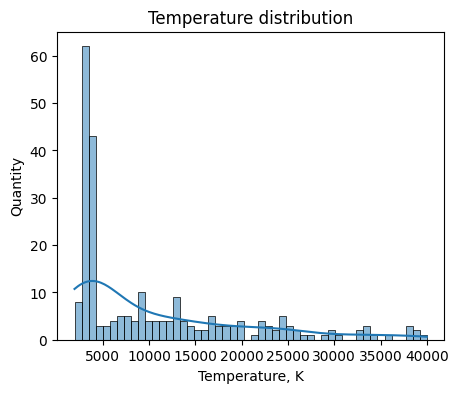

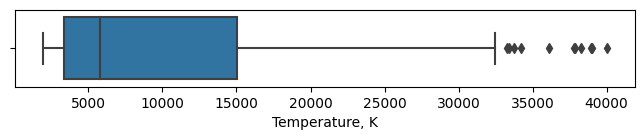

In [10]:
show_distr(df['temperature'], 'Temperature distribution', 'Temperature, K', 'Quantity')


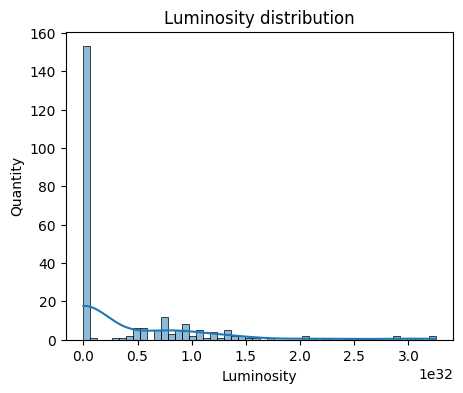

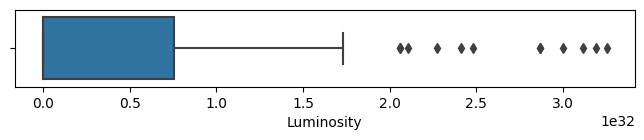

In [11]:
show_distr(df['luminosity'], 'Luminosity distribution', 'Luminosity', 'Quantity')


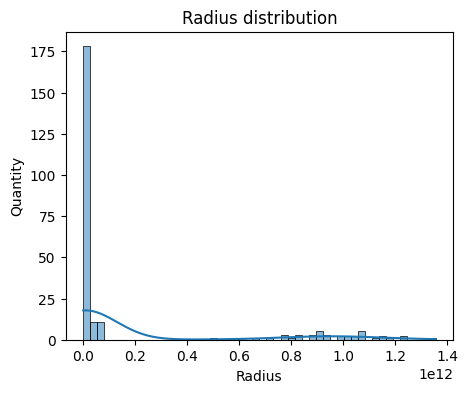

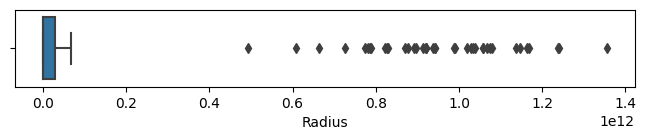

In [12]:
show_distr(df['radius'], 'Radius distribution', 'Radius', 'Quantity')


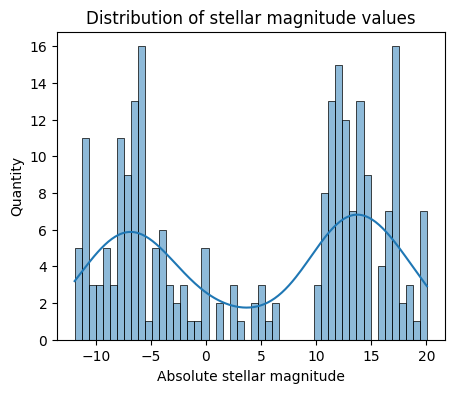

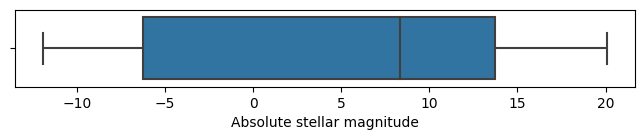

In [13]:
show_distr(df['abs_magnitude'], 'Distribution of stellar magnitude values', 'Absolute stellar magnitude', 'Quantity')


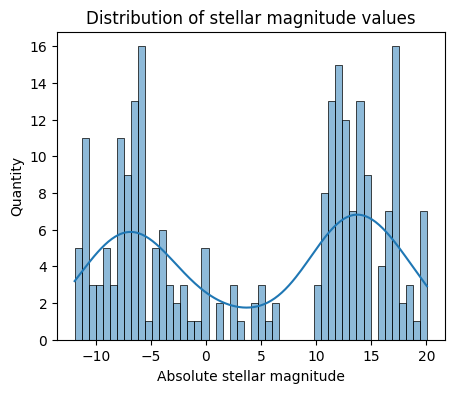

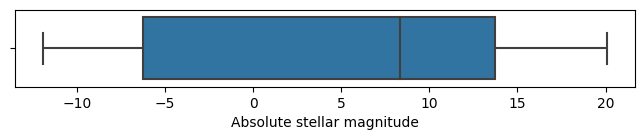

In [14]:
show_distr(df['abs_magnitude'], 'Distribution of stellar magnitude values', 'Absolute stellar magnitude', 'Quantity')


In some features we see anomalous values, but due to the insufficient description of the data it is difficult to conclude whether these are indeed outliers.

Next we consider categorical variables - type and color of the star:

In [15]:
df['star_color'].unique()


array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

The same values written in a different register and with different delimiters are present, let's fix this:

In [16]:
df['star_color']= df['star_color'].str.strip() 
df['star_color']= df['star_color'].str.lower() 

def fix_value(cell):
    """
    replaces spaces with hyphens
    """
    cell = cell.replace(' ', '-') 
    return cell 

df['star_color'] = df['star_color'].apply(fix_value)

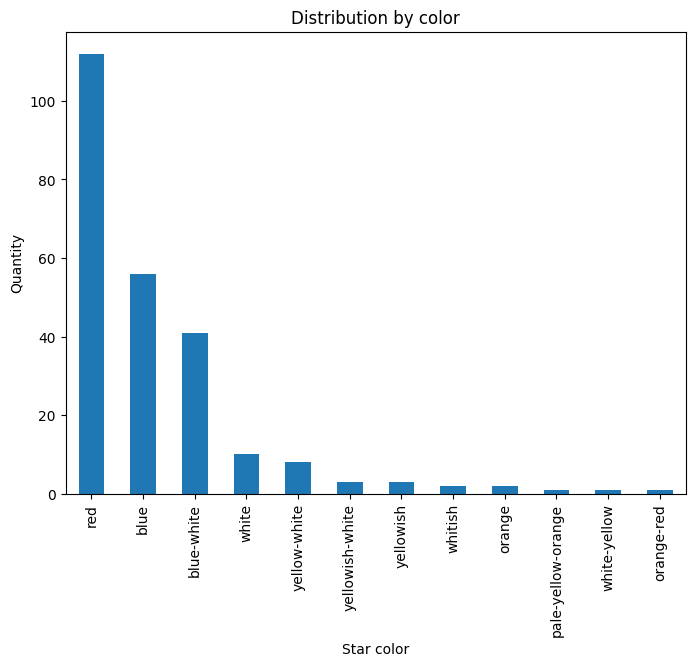

In [17]:
df['star_color'].value_counts().plot(kind='bar', 
                                     title='Distribution by color', 
                                     xlabel='Star color', 
                                     ylabel='Quantity', 
                                     figsize=(8,6));

Red stars are the most represented in the sample

Next, let's look at the distribution of types:

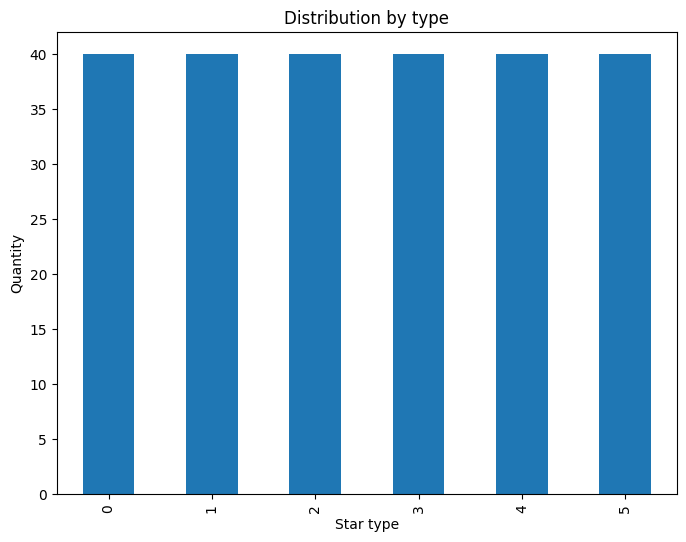

In [18]:
df['star_type'].value_counts().plot(kind='bar', 
                                     title='Distribution by type', 
                                     xlabel='Star type', 
                                     ylabel='Quantity', 
                                     figsize=(8,6));

## Building a basic neural network

Divide the original data into training and test samples - allocate 80% for training and 20% for test.

In [19]:

x_train, x_test, y_train, y_test = train_test_split(df.drop('temperature', axis=1), 
                                                    df['temperature'], 
                                                    train_size=0.8, 
                                                    random_state=42, 
                                                    shuffle=True)

Next, we perform scaling of the quantitative data:

In [20]:
numeric = ['luminosity', 'radius', 'abs_magnitude']

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

Let's encode categorical data with OneHotEncoder:

In [21]:
categorial = ['star_color', 'star_type']

tmp_train = x_train[categorial]
tmp_test= x_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(x_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(x_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=x_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(x_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=x_test.index)

x_train.drop(categorial, axis=1, inplace=True)
x_train = x_train.join(tmp_train)

x_test.drop(categorial, axis=1, inplace=True)
x_test = x_test.join(tmp_test)

Creating feature tensors:

In [22]:
x_train_torch = torch.FloatTensor(x_train.values)
y_train_torch = torch.FloatTensor(y_train.values)
x_test_torch = torch.FloatTensor(x_test.values)
y_test_torch = torch.FloatTensor(y_test.values)

In [23]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

In [24]:
def net_learn(num_epochs, net):
    rmse_best = 50000
    rmse_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
 
        preds = net.forward(x_train_torch).flatten()
            
        loss_value = loss(preds, y_train_torch)

        loss_value.backward()
            
        optimizer.step()
    
      
        net.eval()
        test_preds = net.forward(x_test_torch)
        rmse = mean_squared_error(y_test_torch.detach().numpy(), test_preds.detach().numpy(), squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            test_preds_best = test_preds 
            best_epoch = epoch 
    print('RMSE:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best, rmse_list

Let's set the number of neurons on each layer of the network:

In [25]:
n_in_neurons = x_train.shape[1]
n_hidden_neurons = list(range(300, 1050, 50))       
n_out_neurons = 1                                  

loss = nn.MSELoss()                                

num_epochs = 1500
combinations = 10 

Next, we go through the random combinations and find the optimal one:

In [26]:
for c in range(combinations):
    hidden_size_1 = random.choice(n_hidden_neurons)    
    hidden_size_2 = random.choice(n_hidden_neurons)
    print('hidden 1 =',hidden_size_1, 'hidden 2 =',hidden_size_2)
    net = Net(n_in_neurons, hidden_size_1, hidden_size_2, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    test_preds, rmse_list = net_learn(num_epochs, net)
    print('---------------------------')    

hidden 1 = 750 hidden 2 = 1000
RMSE: 4506.968 | ep 1499 from 1500 | best_epoch: 1079
---------------------------
hidden 1 = 650 hidden 2 = 800
RMSE: 4471.848 | ep 1499 from 1500 | best_epoch: 1215
---------------------------
hidden 1 = 550 hidden 2 = 450
RMSE: 4445.524 | ep 1499 from 1500 | best_epoch: 1296
---------------------------
hidden 1 = 500 hidden 2 = 950
RMSE: 4478.004 | ep 1499 from 1500 | best_epoch: 1083
---------------------------
hidden 1 = 1000 hidden 2 = 350
RMSE: 4441.196 | ep 1499 from 1500 | best_epoch: 1234
---------------------------
hidden 1 = 400 hidden 2 = 450
RMSE: 4426.406 | ep 1499 from 1500 | best_epoch: 1391
---------------------------
hidden 1 = 450 hidden 2 = 700
RMSE: 4444.52 | ep 1499 from 1500 | best_epoch: 1182
---------------------------
hidden 1 = 550 hidden 2 = 450
RMSE: 4410.338 | ep 1499 from 1500 | best_epoch: 1255
---------------------------
hidden 1 = 350 hidden 2 = 750
RMSE: 4371.868 | ep 1499 from 1500 | best_epoch: 1450
-------------------

The optimal combination of 400 neurons on the first layer and 550 on the second layer gives an RMSE value of 4422.026, which is within the specified limit of 4500.

Now let us plot the "Actual - Prediction" graph, where the horizontal axis shows the conditional numbers of stars and the vertical axis shows the temperature in Kelvin:

In [27]:
net = Net(n_in_neurons, 400, 450, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
test_preds, rmse_list = net_learn(num_epochs, net)

RMSE: 4424.47 | ep 1499 from 1500 | best_epoch: 1316


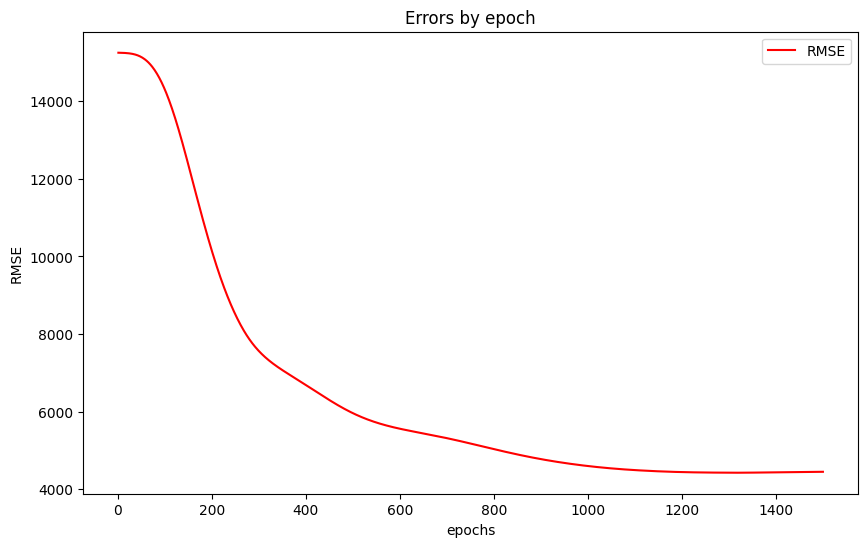

In [28]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=[10,6])
sns.lineplot(x=epochs, y=rmse_list, label='RMSE', color='red')
plt.legend()
plt.title('Errors by epoch')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()

From the graph, we see that the model stops learning after about epoch 1000.

In [29]:
test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])  # преобразуем данные
y_test = pd.DataFrame((y_test), columns=['temperature']).reset_index().drop('index', axis=1)

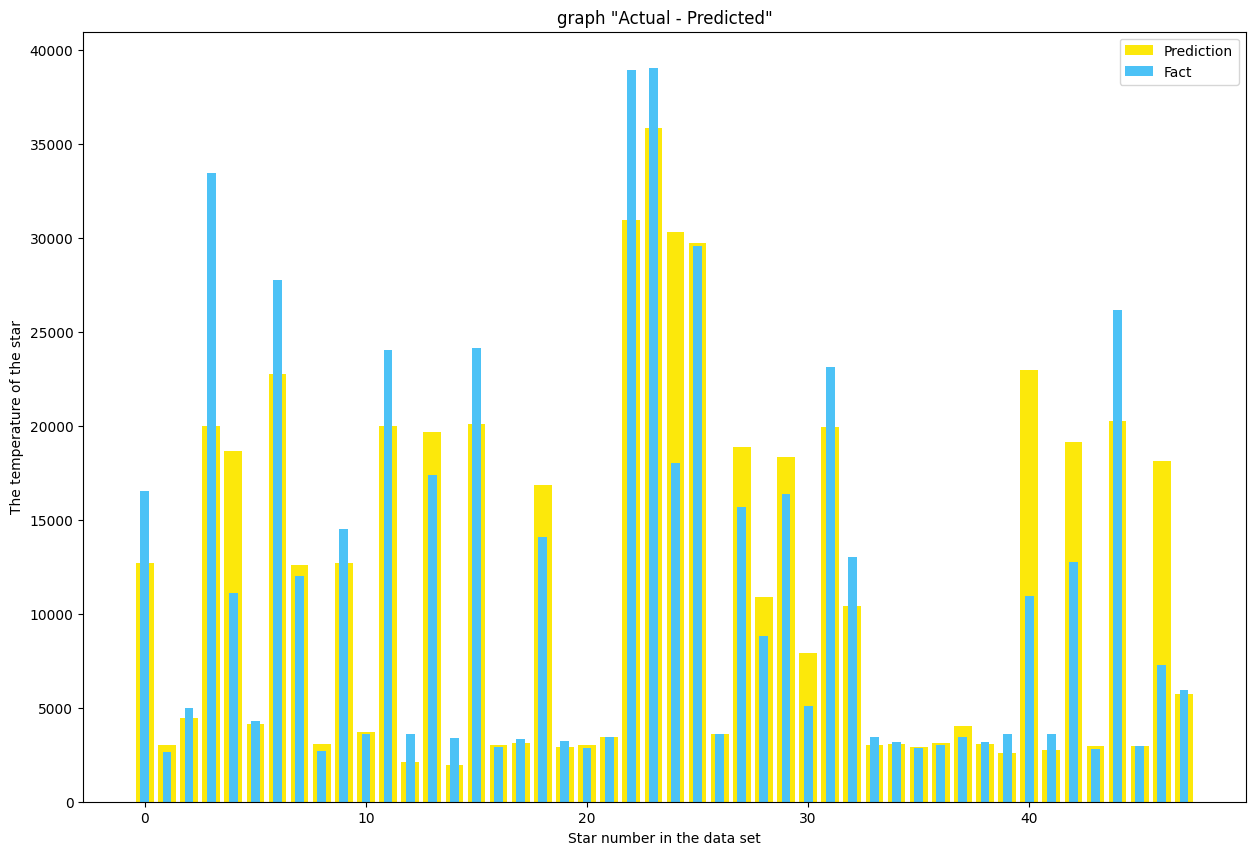

In [30]:
fig, ax = plt.subplots(figsize=[15,10])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='#fce80b' , label='Prediction')
plt.bar(x=y_test.index, height=y_test['temperature'], color='#4cc2f6', label='Fact', width= 0.4)
plt.title('graph "Actual - Predicted"')
plt.xlabel('Star number in the data set')
plt.ylabel('The temperature of the star')
ax.legend()
plt.show()

## Improving the neural network

Let's create a solution with a brute force search of neural network parameters. 

In [31]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid

class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        
        return out

def net_learn(num_epochs, net, train_loader):
    rmse_best = 50000
    rmse_list = []
    for epoch in range(num_epochs):
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()

            preds = net.forward(inputs).flatten()

            loss_value = loss(preds, targets)

            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(x_test_torch)
        rmse = mean_squared_error(y_test_torch.detach().numpy(), test_preds.detach().numpy(), squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            test_preds_best = test_preds 
            best_epoch = epoch 
    print('RMSE:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best, rmse_list




In [32]:
param_grid = {
    'hidden_size1': [400],
    'hidden_size2': [450],
    'dropout': [0.1, 0.3, 0.5],
    'batch_size': [32, 64, 128]
}

combinations = ParameterGrid(param_grid)

n_in_neurons = x_train.shape[1]
n_out_neurons = 1  

loss = nn.MSELoss() 

num_epochs = 1500

for params in combinations:
    train_data = TensorDataset(x_train_torch, y_train_torch)
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    
    print('hidden 1 =',params['hidden_size1'], 'hidden 2 =',params['hidden_size2'], 'dropout =',params['dropout'], 'batch_size =',params['batch_size'])
    net = Net(n_in_neurons, params['hidden_size1'], params['hidden_size2'], n_out_neurons, params['dropout'])
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    test_preds, rmse_list = net_learn(num_epochs, net, train_loader)
    print('---------------------------')

hidden 1 = 400 hidden 2 = 450 dropout = 0.1 batch_size = 32
RMSE: 4461.744 | ep 1499 from 1500 | best_epoch: 620
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.3 batch_size = 32
RMSE: 4478.052 | ep 1499 from 1500 | best_epoch: 656
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.5 batch_size = 32
RMSE: 4501.64 | ep 1499 from 1500 | best_epoch: 639
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.1 batch_size = 64
RMSE: 4445.27 | ep 1499 from 1500 | best_epoch: 897
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.3 batch_size = 64
RMSE: 4460.716 | ep 1499 from 1500 | best_epoch: 861
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.5 batch_size = 64
RMSE: 4440.569 | ep 1499 from 1500 | best_epoch: 966
---------------------------
hidden 1 = 400 hidden 2 = 450 dropout = 0.1 batch_size = 128
RMSE: 4383.7 | ep 1499 from 1500 | best_epoch: 1367
---------------------------
hidden 1 = 400 

Dropout values of 0.1 and 0.5 perform best with RMSE results of 4379.672 and 4382.624. 

In [33]:
drop_test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])
test_preds_df = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])


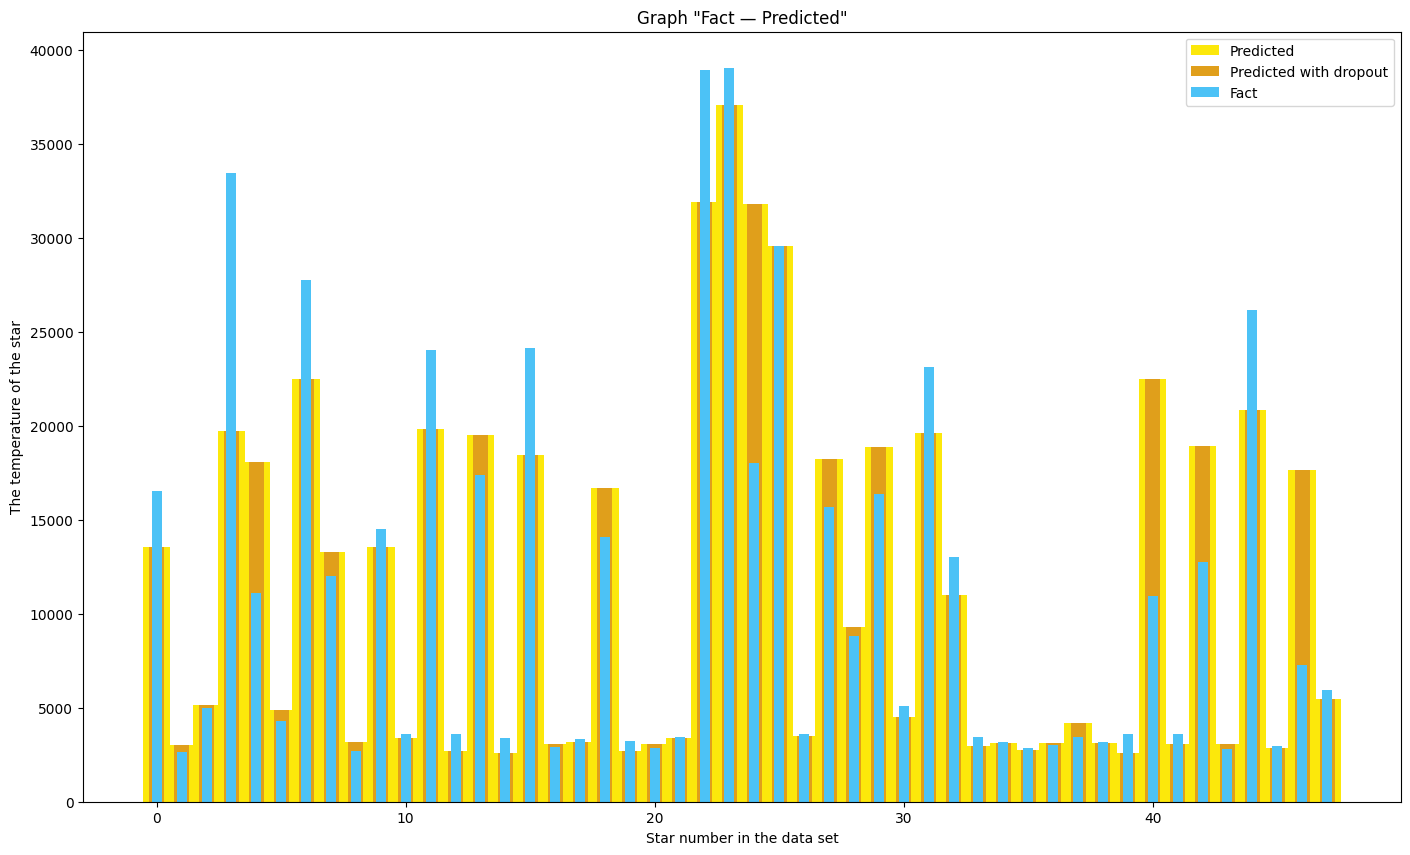

In [34]:
fig, ax = plt.subplots(figsize=[17,10])
plt.bar(x=test_preds_df.index, height=test_preds_df['temperature'], color='#fce80b' , label='Predicted', width= 1.1)
plt.bar(x=drop_test_preds.index, height=drop_test_preds['temperature'], color='#e09f1b' , label='Predicted with dropout', width= 0.6)

plt.bar(x=y_test.index, height=y_test['temperature'], color='#4cc2f6', label='Fact', width= 0.4)
plt.title('Graph "Fact — Predicted"')
plt.xlabel('Star number in the data set')
plt.ylabel('The temperature of the star')
ax.legend()
plt.show()

## Conclusions

On such a small amount of data it is not reasonable to use the network training with the help of batches, as well as to carry out regularization - both models show approximately the same values of RMSE ~ 4400, which is within the specified limit of 4500.